In [10]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [12]:
from ultralytics import YOLO

yolo_model = YOLO("yolov8s.pt") 
yolo_model.to(device)           
yolo_model.eval()


YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(96, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_s

In [13]:
import os

val_dir = "./val2017"  # 或者使用绝对路径
list_of_img_paths = []

for fname in os.listdir(val_dir):
    if fname.endswith(".jpg"):
        list_of_img_paths.append(os.path.join(val_dir, fname))

# 现在 list_of_img_paths 就包含了所有 val2017/*.jpg 的完整路径
print("Total images:", len(list_of_img_paths))


Total images: 5000


# **YOLO**

## Average Detection Latency

In [14]:
import time

total_time = 0.0
num_images = 0

for img_path in list_of_img_paths:  
    start_time = time.time()
    results = yolo_model.predict(img_path, conf=0.25) 
    end_time = time.time()
    
    latency = end_time - start_time
    total_time += latency
    num_images += 1

avg_latency = total_time / num_images
print("YOLO Average Detection Latency:", avg_latency)



image 1/1 d:\CMU\DL\final\val2017\000000000139.jpg: 448x640 3 persons, 3 chairs, 2 potted plants, 1 dining table, 2 tvs, 2 refrigerators, 1 clock, 2 vases, 27.8ms
Speed: 3.4ms preprocess, 27.8ms inference, 106.2ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 d:\CMU\DL\final\val2017\000000000285.jpg: 640x608 1 bear, 26.5ms
Speed: 1.2ms preprocess, 26.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 608)

image 1/1 d:\CMU\DL\final\val2017\000000000632.jpg: 512x640 1 bottle, 1 chair, 2 potted plants, 1 bed, 1 vase, 22.8ms
Speed: 0.8ms preprocess, 22.8ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 d:\CMU\DL\final\val2017\000000000724.jpg: 640x480 1 truck, 2 stop signs, 47.8ms
Speed: 3.0ms preprocess, 47.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 d:\CMU\DL\final\val2017\000000000776.jpg: 640x448 2 teddy bears, 22.5ms
Speed: 0.6ms preprocess, 22.5ms inference, 0.8ms postprocess per image at sha


image 1/1 d:\CMU\DL\final\val2017\000000567640.jpg: 448x640 10 persons, 2 cars, 1 sports ball, 5.3ms
Speed: 0.7ms preprocess, 5.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


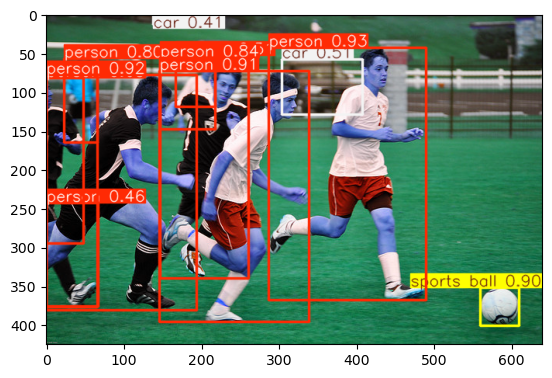

In [17]:
results = yolo_model.predict("val2017/000000567640.jpg")
annotated_frame = results[0].plot()  # returns a numpy array with drawings
import matplotlib.pyplot as plt
plt.imshow(annotated_frame)
plt.show()


## Process the images in batches
Save them in json files

In [7]:
import os
import json
from math import ceil
from ultralytics import YOLO

def chunk_list(lst, chunk_size):
    """Yield successive chunk_size-sized sublists from lst."""
    for i in range(0, len(lst), chunk_size):
        yield lst[i : i + chunk_size]

def parse_yolo_result(img_path, res):
    """
    Given one YOLO result (res) for a single image (img_path),
    parse each detected box and return a list of prediction dicts:
      {
        "image_id": int,
        "class_id": int,
        "bbox": [x1, y1, x2, y2],
        "score": float
      }
    You can adjust this function as needed.
    """
    # Derive image_id from filename, e.g. "000000567640.jpg" => 567640
    filename = os.path.basename(img_path)
    image_id = int(os.path.splitext(filename)[0])

    # Convert GPU Tensors to CPU, then to numpy
    boxes_xyxy = res.boxes.xyxy.cpu().numpy()  # shape (N,4)
    scores     = res.boxes.conf.cpu().numpy()  # shape (N,)
    classes    = res.boxes.cls.cpu().numpy()   # shape (N,)

    predictions = []
    for i in range(len(boxes_xyxy)):
        x1, y1, x2, y2 = boxes_xyxy[i]
        conf          = float(scores[i])
        cls_id        = int(classes[i])
        predictions.append({
            "image_id": image_id,
            "class_id": cls_id,
            "bbox": [float(x1), float(y1), float(x2), float(y2)],
            "score": conf
        })
    return predictions


def run_inference_in_chunks(model, image_paths, chunk_size=500, batch_size=16, output_dir="pred_chunks"):
    """
    Process 'image_paths' in chunks. For each chunk:
      1) Run YOLO inference in batch (size=batch_size).
      2) Parse each result -> a list of prediction dicts.
      3) Save that list to a JSON file in 'output_dir'.

    Returns: A list of JSON file paths, each containing chunk results.
    """
    os.makedirs(output_dir, exist_ok=True)
    chunk_files = []

    for chunk_idx, sub_paths in enumerate(chunk_list(image_paths, chunk_size)):
        print(f"\n=== Processing chunk {chunk_idx+1} with {len(sub_paths)} images ===")

        # 1) YOLO batch inference
        #    'results' is a list of 'Results' objects, each corresponding to one image in sub_paths.
        results = model.predict(
            source=sub_paths,
            conf=0.25,
            device="cuda",
            imgsz=640,
            batch=batch_size
        )

        # 2) Parse results
        chunk_predictions = []
        for img_path, res in zip(sub_paths, results):
            preds_for_image = parse_yolo_result(img_path, res)
            # Accumulate into chunk_predictions
            chunk_predictions.extend(preds_for_image)

        # 3) Save chunk results to JSON
        out_file = os.path.join(output_dir, f"predictions_chunk_{chunk_idx}.json")
        with open(out_file, "w") as f:
            json.dump(chunk_predictions, f)

        chunk_files.append(out_file)
        print(f"Chunk {chunk_idx+1} saved to {out_file}.")

    return chunk_files



# 0. Prepare your model and image list
model = YOLO("yolov8s.pt")


# 1. Run inference in chunks, each chunk using batch=16
chunk_json_files = run_inference_in_chunks(
    model,
    list_of_img_paths,
    chunk_size=500,
    batch_size=16,
    output_dir="pred_chunks"
)

print("\nAll chunk predictions saved. JSON files:")
for path in chunk_json_files:
    print(" -", path)




=== Processing chunk 1 with 500 images ===

0: 640x640 3 persons, 1 bottle, 3 chairs, 2 potted plants, 2 dining tables, 2 tvs, 2 refrigerators, 1 clock, 2 vases, 73.3ms
1: 640x640 1 bear, 73.3ms
2: 640x640 1 bottle, 1 chair, 2 potted plants, 1 bed, 1 vase, 73.3ms
3: 640x640 2 trucks, 2 stop signs, 73.3ms
4: 640x640 2 teddy bears, 73.3ms
5: 640x640 1 person, 1 skis, 73.3ms
6: 640x640 1 oven, 1 refrigerator, 73.3ms
7: 640x640 2 persons, 1 sports ball, 73.3ms
8: 640x640 9 persons, 1 sports ball, 1 tennis racket, 73.3ms
9: 640x640 14 persons, 1 handbag, 2 tennis rackets, 73.3ms
10: 640x640 4 persons, 1 bird, 1 handbag, 2 cell phones, 73.3ms
11: 640x640 4 persons, 1 cell phone, 73.3ms
12: 640x640 6 persons, 1 suitcase, 1 chair, 73.3ms
13: 640x640 1 bowl, 1 sandwich, 73.3ms
14: 640x640 1 person, 1 surfboard, 73.3ms
15: 640x640 1 tv, 1 laptop, 2 mouses, 2 keyboards, 73.3ms
16: 640x640 5 cars, 3 trucks, 73.3ms
17: 640x640 5 persons, 3 buss, 73.3ms
18: 640x640 1 cat, 1 laptop, 73.3ms
19: 640x6

## Reload them back here

In [1]:
all_predictions = []
import os
import json
from math import ceil
from ultralytics import YOLO
for i in range(10):
    with open(str('pred_chunks/predictions_chunk_'+f'{i}.json'), "r") as f:
        preds = json.load(f)
    all_predictions.extend(preds)

# then compute_mAP(all_predictions, ground_truths, iou_thresh=0.5, ...)

In [2]:
all_predictions[-5:]

[{'image_id': 581781,
  'class_id': 46,
  'bbox': [0.10082435607910156,
   0.3765869140625,
   18.624116897583008,
   143.06658935546875],
  'score': 0.330413818359375},
 {'image_id': 581781,
  'class_id': 46,
  'bbox': [90.91949462890625,
   86.76031494140625,
   157.04226684570312,
   142.44821166992188],
  'score': 0.3182142376899719},
 {'image_id': 581781,
  'class_id': 46,
  'bbox': [507.1354064941406,
   148.2093963623047,
   572.0311279296875,
   219.16278076171875],
  'score': 0.2811453342437744},
 {'image_id': 581781,
  'class_id': 46,
  'bbox': [71.61311340332031,
   88.46945190429688,
   176.2926025390625,
   175.28643798828125],
  'score': 0.27489224076271057},
 {'image_id': 581781,
  'class_id': 46,
  'bbox': [465.74322509765625,
   278.51971435546875,
   639.4754028320312,
   469.526123046875],
  'score': 0.2504860758781433}]

## mAP for YOLO
I wrote some essential functions for mapping the categories in `utils_coco.py`

**The greatest problem here is that YOLO's class is different with COCO's category.**

In [3]:
# Suppose we saved the file as "utils_coco.py"
from utils_coco import (
    load_coco_categories,
    load_coco_annotations,
    visualize_detections,
    compute_mAP
)

# 1) Build category mappings
cat_id_to_name, cat_id_to_class_id = load_coco_categories("annotations/instances_val2017.json")

# 2) Load ground truths
all_ground_truths = load_coco_annotations("annotations/instances_val2017.json", cat_id_to_class_id)

# 3) Suppose you already have YOLO predictions "all_predictions"
#    in the form [ {image_id, class_id, bbox, score}, ... ]

# 4) Compute mAP (IoU=0.5)
mAP_50 = compute_mAP(all_predictions, all_ground_truths, num_classes=80, iou_thresh=0.5)
print("mAP @0.5:", mAP_50)




mAP @0.5: 0.5198136544363064


**YOLO: mAP: 0.5198136544363064**

In [5]:
# 5) Visual check on a single image
img_id = 201775
img_file = "val2017/000000201775.jpg"
gt_for_img = [gt for gt in all_ground_truths if gt["image_id"] == img_id]
pred_for_img = [p for p in all_predictions if p["image_id"] == img_id]

# Build your YOLO class names list in ascending order (0..79) matching cat_id_to_class_id
class_names = range(80)  # or ['person', 'bicycle', ...] etc.
# Then visualize:
visualize_detections(img_file, gt_for_img, pred_for_img, class_names)

# **FRCNN**

In [ ]:
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn

frcnn_model = fasterrcnn_resnet50_fpn(pretrained=True)
frcnn_model.to(device)
frcnn_model.eval()

c:\Users\Daren\anaconda3\envs\torchgpu\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Daren\anaconda3\envs\torchgpu\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

## Average Detection Latency

In [ ]:
import time
from PIL import Image
import torchvision.transforms as T

transform = T.Compose([
    T.ToTensor(),
])

total_time = 0.0
num_images = 0

for img_path in list_of_img_paths:
    image = Image.open(img_path).convert("RGB")
    img_tensor = transform(image).unsqueeze(0).to(device)  # batch=1

    start_time = time.time()
    with torch.no_grad():
        outputs = frcnn_model(img_tensor)
    end_time = time.time()

    latency = end_time - start_time
    total_time += latency
    num_images += 1

avg_latency = total_time / num_images
print("Faster R-CNN Average Detection Latency）:", avg_latency)


Faster R-CNN Average Detection Latency）: 0.027700710868835448


## mAP for FRCNN

In [2]:
import os
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import torchvision.transforms as T
from utils_coco import (
    gather_frcnn_predictions_in_chunks,
    load_chunk_predictions,
    load_coco_annotations_withoutmapping,
    compute_mAP
)
# 1. Prepare model
device = "cuda"
frcnn_model = fasterrcnn_resnet50_fpn(pretrained=True)
frcnn_model.to(device)
frcnn_model.eval()

# 2. Gather predictions in chunks
image_dir = "val2017"
image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(".jpg")]
chunk_files = gather_frcnn_predictions_in_chunks(
    frcnn_model,
    image_paths,
    chunk_size=500,
    batch_size=1,
    score_thr=0.0,          # or 0.05, etc.
    output_dir="frcnn_pred_chunks"
)

# 3. Load all chunk predictions
all_predictions = load_chunk_predictions(chunk_files)

# 4. Load ground truths (only cat_id in [1..80])
ann_file = "annotations/instances_val2017.json"
all_ground_truths = load_coco_annotations_withoutmapping(ann_file, max_cat=80)

# 5. Compute mAP
mAP_50 = compute_mAP(all_predictions, all_ground_truths, num_classes=81, iou_thresh=0.5)
print("Faster R-CNN mAP @0.5:", mAP_50)


c:\Users\Daren\anaconda3\envs\torchgpu\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Daren\anaconda3\envs\torchgpu\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



=== Processing chunk 1 with 500 images ===
Chunk 1 saved to frcnn_pred_chunks\predictions_chunk_0.json.

=== Processing chunk 2 with 500 images ===
Chunk 2 saved to frcnn_pred_chunks\predictions_chunk_1.json.

=== Processing chunk 3 with 500 images ===
Chunk 3 saved to frcnn_pred_chunks\predictions_chunk_2.json.

=== Processing chunk 4 with 500 images ===
Chunk 4 saved to frcnn_pred_chunks\predictions_chunk_3.json.

=== Processing chunk 5 with 500 images ===
Chunk 5 saved to frcnn_pred_chunks\predictions_chunk_4.json.

=== Processing chunk 6 with 500 images ===
Chunk 6 saved to frcnn_pred_chunks\predictions_chunk_5.json.

=== Processing chunk 7 with 500 images ===
Chunk 7 saved to frcnn_pred_chunks\predictions_chunk_6.json.

=== Processing chunk 8 with 500 images ===
Chunk 8 saved to frcnn_pred_chunks\predictions_chunk_7.json.

=== Processing chunk 9 with 500 images ===
Chunk 9 saved to frcnn_pred_chunks\predictions_chunk_8.json.

=== Processing chunk 10 with 500 images ===
Chunk 10 s

**Faster R-CNN mAP: 0.5840181791713694**